# OpenAI's codex model for code generation
You can use OpenAI's codex model for code generation.

In [1]:
from bia_bob import bob
from skimage.io import imread
import stackview

In [2]:
bob.initialize(model="codex-mini-latest", vision_model="codex-mini-latest")

The codex model has vision capabilities. We just load a screenshot...

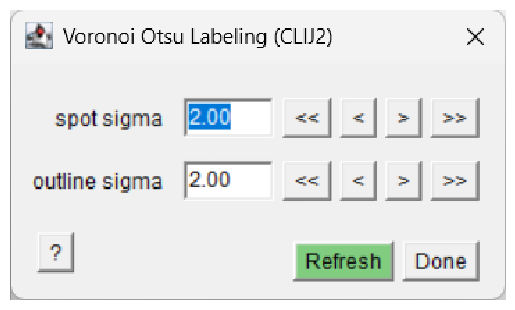

In [3]:
screenshot = imread("gui_screenshot.png")

stackview.imshow(screenshot)

... and pass this screenshot to bob, asking it to reimplement the shown interface.

In [4]:
%%bob screenshot
Build a user-interface similar to the given screenshot image.
Instead of ?, Refresh and Done buttons, just implement an OK button.
Make it reusable as a function, which takes a callback-function that is provided with the configurable parameters.

I will create a small reusable ipywidgets‑based dialog that mimics the “spot sigma” / “outline sigma” rows with « << < > >> buttons and an OK button. The dialog is wrapped in a function that accepts a user callback; when the user clicks OK the callback is invoked with the two sigma values.



In [5]:
import ipywidgets as widgets
from IPython.display import display

def _make_sigma_row(name, init_value=2.0, small_step=0.1, large_step=1.0):
    """
    Build one row: [Label] [FloatText] [<<] [<] [>] [>>]
    Returns the FloatText widget and the row container.
    """
    ft = widgets.FloatText(value=init_value, layout=widgets.Layout(width='60px'))
    btn_ll = widgets.Button(description='<<', layout=widgets.Layout(width='30px'))
    btn_l  = widgets.Button(description='<',  layout=widgets.Layout(width='30px'))
    btn_r  = widgets.Button(description='>',  layout=widgets.Layout(width='30px'))
    btn_rr = widgets.Button(description='>>', layout=widgets.Layout(width='30px'))

    def dec_large(_): ft.value = ft.value - large_step
    def dec_small(_): ft.value = ft.value - small_step
    def inc_small(_): ft.value = ft.value + small_step
    def inc_large(_): ft.value = ft.value + large_step

    btn_ll.on_click(dec_large)
    btn_l .on_click(dec_small)
    btn_r .on_click(inc_small)
    btn_rr.on_click(inc_large)

    row = widgets.HBox([
        widgets.Label(name, layout=widgets.Layout(width='100px')),
        ft, btn_ll, btn_l, btn_r, btn_rr
    ])
    return ft, row

def sigma_dialog(on_ok_callback):
    """
    Display a dialog to configure spot sigma and outline sigma.
    When OK is clicked, calls on_ok_callback(spot_sigma, outline_sigma).
    """
    title = widgets.Label(
        value="Voronoi Otsu Labeling",
        layout=widgets.Layout(margin='0 0 10px 0', font_weight='bold')
    )

    spot_ft, spot_row       = _make_sigma_row("spot sigma",    init_value=2.0)
    outline_ft, outline_row = _make_sigma_row("outline sigma", init_value=2.0)

    ok_button = widgets.Button(description='OK', button_style='success')
    output    = widgets.Output()

    def _on_ok(_):
        with output:
            output.clear_output()
            on_ok_callback(spot_ft.value, outline_ft.value)

    ok_button.on_click(_on_ok)

    dialog = widgets.VBox([title, spot_row, outline_row, ok_button, output])
    display(dialog)

def my_callback(spot_sigma, outline_sigma):
    print(f"User set spot_sigma={spot_sigma}, outline_sigma={outline_sigma}")

sigma_dialog(my_callback)

In [6]:
%%bob 
Load blobs.tif,
collect image processing parameters using the just created user interface and 
process the image using Voronoi-Otsu-Labeling and the user-defined parameters.

We will load **blobs.tif**, then invoke our previously defined `sigma_dialog` UI to collect **spot sigma** and **outline sigma** from the user. Once the user clicks **OK**, we’ll run GPU‑accelerated Voronoi‑Otsu segmentation (`cle.voronoi_otsu_labeling`) with the chosen parameters, store the label image in a variable for later reuse, and display it.

---



In [7]:
import pyclesperanto as cle

# 1. Load the image
image = imread("blobs.tif")

# 2. Prepare a variable to hold the result
label_image = None

# 3. Define the callback that performs Voronoi‑Otsu labeling
def process_blobs(spot_sigma, outline_sigma):
    global label_image
    label_image = cle.voronoi_otsu_labeling(
        image,
        spot_sigma=spot_sigma,
        outline_sigma=outline_sigma
    )
    # Display the resulting labels
    display(label_image)

# 4. Launch the sigma‑selection dialog
sigma_dialog(process_blobs)